# Aprendizaje Automático: Laboratorio 1
#### Dataset: Red Wine Quality
#### Realizado por Elías Gelczynski, Martín Riesgo y Guillermo Robatto
#### Profesor: Sebastían Parra

In [1]:
%%html
<style>
.container { width:100% !important; }
.notebook { padding-left: 0px !important; }
</style>
#Formato de notebook

In [2]:
import psycopg2
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
#Librerias generales

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix #Clasificación
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.metrics import mean_squared_error, r2_score #Regresión
#Importación de herramientas de scikit-learn

from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
#Importación de modelos


# Parte 0
### Importación de dataset vía Postgre SQL 15

In [3]:
conn = psycopg2.connect(
    host="localhost",
    database="wine",
    user="usuario",
    password="12345")

cursor = conn.cursor()

In [4]:
df = pd.read_sql("SELECT * FROM public.wine_quality", conn)

C:\Users\egelczynski\Anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [5]:
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.2,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.997,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.998,3.16,0.58,9.8,6
4,7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Parte 1
El dataset a estudiar brinda un conjunto de datos de calidad de diferentes vinos tintos: rojos y blancos. En este caso, la calidad de los vinos se mide bajo la opinión de sommeliers certificados capaces de brindar información esencial sobre la bebida investigada, tomando así, la decisión final en la evaluación de los vinos. 

Sin embargo, sería muy beneficioso desarrollar un sistema que pueda ayudar significativamente a los catadores de vino y también a los entusiastas sin conocimientos técnicos para evaluar la calidad de los vinos. 

El objetivo principal de este proyecto es generar herramientas automáticas basadas en el aprendizaje automático para evaluar la calidad de los vinos para generar una predicción de la calidad de un vino y comprobar si coincide con la calidad real. 

Para realizar este estudio, nos fue suministrado el dataset mencionado, acerca de vinos provienentes de la Comisión Vitivinícola de la Región Vinho Verde de Porto, Portugal.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1632 entries, 0 to 1631
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   fixed_acidity         1632 non-null   object
 1   volatile_acidity      1632 non-null   object
 2   citric_acid           1632 non-null   object
 3   residual_sugar        1632 non-null   object
 4   chlorides             1632 non-null   object
 5   free_sulfur_dioxide   1632 non-null   object
 6   total_sulfur_dioxide  1632 non-null   object
 7   density               1632 non-null   object
 8   pH                    1632 non-null   object
 9   sulphates             1632 non-null   object
 10  alcohol               1632 non-null   object
 11  quality               1632 non-null   int64 
dtypes: int64(1), object(11)
memory usage: 153.1+ KB


Podemos ver que tiene los datos correspondientes a 1632 vinos diferentes. Cada uno de los vinos tiene 12 características que usaremos para determinar la calidad (que será nuestra columna objetivo).
Al observar los tipos de datos en las columnas, vemos que no son de tipo númerico: Puede que tengan algún dato no transformable a un tipo númerico.

A continuacion checkeamos los missing values:

In [7]:
df.isnull().any()

fixed_acidity           False
volatile_acidity        False
citric_acid             False
residual_sugar          False
chlorides               False
free_sulfur_dioxide     False
total_sulfur_dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
dtype: bool

No hay columnas con valores nulos.

In [8]:
df.dtypes

fixed_acidity           object
volatile_acidity        object
citric_acid             object
residual_sugar          object
chlorides               object
free_sulfur_dioxide     object
total_sulfur_dioxide    object
density                 object
pH                      object
sulphates               object
alcohol                 object
quality                  int64
dtype: object

In [9]:
# Sabiendo que puede que hayan datos que no sean transformables a un tipo númerico, creamos la siguiente función para detectarlos.
def cambiar_tipo_dato(df, tipo_nuevo):
    index_error = {column: [] for column in df.columns}
    for column in df.columns:
        for index, value in enumerate(df[column]):
            try:
                df[column].iloc[index] = tipo_nuevo(value)
            except ValueError:
                index_error[column].append(index)
    return index_error
#Esta función no cambia el tipo de dato, intenta y si no lo logra, retorna el índice.

In [10]:
index_object = cambiar_tipo_dato(df, float)
print(index_object)

{'fixed_acidity': [], 'volatile_acidity': [], 'citric_acid': [], 'residual_sugar': [], 'chlorides': [], 'free_sulfur_dioxide': [], 'total_sulfur_dioxide': [], 'density': [811], 'pH': [], 'sulphates': [], 'alcohol': [1353, 1356, 1433, 1435, 1469, 1506, 1595], 'quality': []}


Para las columnas que contienen datos no transformables a float, obtuvimos sus índices.

In [11]:
df.iloc[index_object["density"]]

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
811,12.9,0.5,0.55,2.8,0.072,7.0,24.0,10.001.200.000.000.000,3.09,0.68,10.9,6


In [12]:
df.iloc[index_object["alcohol"]]

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
1353,11.6,0.475,0.4,1.4,0.091,6.0,28.0,0.99704,3.07,0.65,100.333.333.333.333,6
1356,11.6,0.475,0.4,1.4,0.091,6.0,28.0,0.99704,3.07,0.65,100.333.333.333.333,6
1433,7.3,0.67,0.02,2.2,0.072,31.0,92.0,0.99566,3.32,0.68,11.066.666.666.666.600,6
1435,7.4,0.785,0.19,5.2,0.094,19.0,98.0,0.99713,3.16,0.52,956.666.666.666.667,6
1469,5.3,0.47,0.11,2.2,0.048,16.0,89.0,0.99182,3.54,0.88,13.566.666.666.666.600,7
1506,6.9,0.84,0.21,4.1,0.074,16.0,65.0,0.99842,3.53,0.72,923.333.333.333.333,6
1595,5.3,0.47,0.11,2.2,0.048,16.0,89.0,0.99182,3.54,0.88,13.566.666.666.666.600,7


Ambas filas toman valores incoherentes y por formato del valor, no pueden ser cambiados a valores de tipo float. Ya que son 8 filas de 1632, un porcentaje ínfimo del total, decidimos eliminar estos registros

In [13]:
for index in [index_object["density"] + index_object["alcohol"]]:
    df.drop(index=index, axis=0,inplace=True)

In [14]:
cambiar_tipo_dato(df, float)

{'fixed_acidity': [],
 'volatile_acidity': [],
 'citric_acid': [],
 'residual_sugar': [],
 'chlorides': [],
 'free_sulfur_dioxide': [],
 'total_sulfur_dioxide': [],
 'density': [],
 'pH': [],
 'sulphates': [],
 'alcohol': [],
 'quality': []}

### El diccionario retorna vacío, todas las variables pueden ser transformadas a tipo float.

In [15]:
df = df.astype(float)

In [16]:
#Para checkear:
df.dtypes

fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                 float64
dtype: object

### Sabiendo que la variable quality va de 0 a 10 y el pH no puede tomar valores fuera del rango de 1 a 14:

In [17]:
df.drop(df[df['quality'] > 10].index, inplace=True)
df.drop(df[(df['pH'] > 14) | (df['pH'] < 1)].index, inplace=True)

### Matriz de correlación

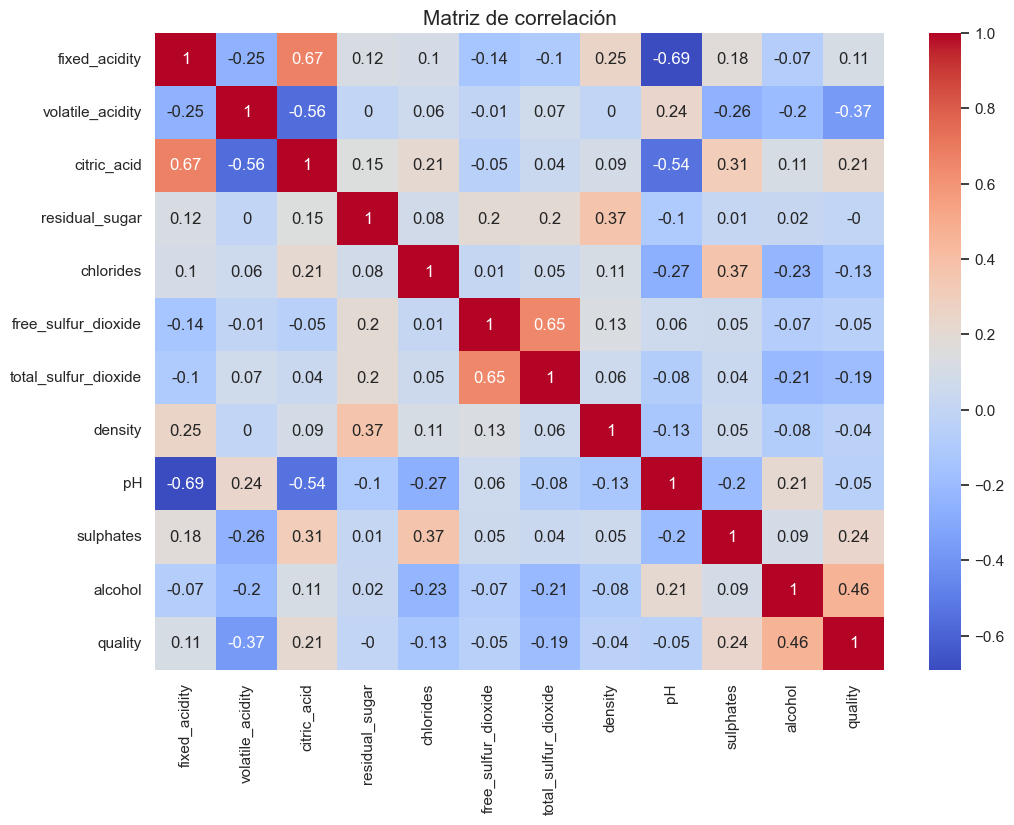

In [18]:
correlation = df.corr().round(2)

with sns.plotting_context("notebook", font_scale=1.2):
    sns.set_style("ticks")
    sns.set_palette("coolwarm") 
    sns.set(rc={"figure.figsize":(11.75,8.27)})

    sns.heatmap(data=correlation, annot=True, cmap="coolwarm")

plt.title("Matriz de correlación", fontsize=15)

plt.show()

Continuando, generamos un ‘heatmap’ para verificar las correlaciones entre las variables. A partir de esta matriz podemos observar, algunas correlaciones claras entre algunas características como el ‘citric acid’ y ‘fixed acidity’. También podemos observar que aproximadamente la mitad de estas características se correlacionan positivamente con la calidad, mientras que la otra mitad se correlaciona negativamente.
Observamos cómo variables como la acidez fija tienen una fuerte correlación con características como el ácido cítrico (lo cual tiene sentido) y la densidad.

### Vemos como nuestro valor objetivo tiene una correlación fuerte con el alcohol y muestra casi ninguna correlación con el azúcar residual.

# Parte 2
Partiendo de los atributos de características del vino utilice el método de regresión
lineal para predecir la calidad de este. Analice los resultados obtenidos. Revise y
discuta si existen mecanismos para mejorar las métricas que arroja este modelo.

#### Como parte del EDA, debemos evaluar estadísticamente los atributos, hallando outliers por boxplots

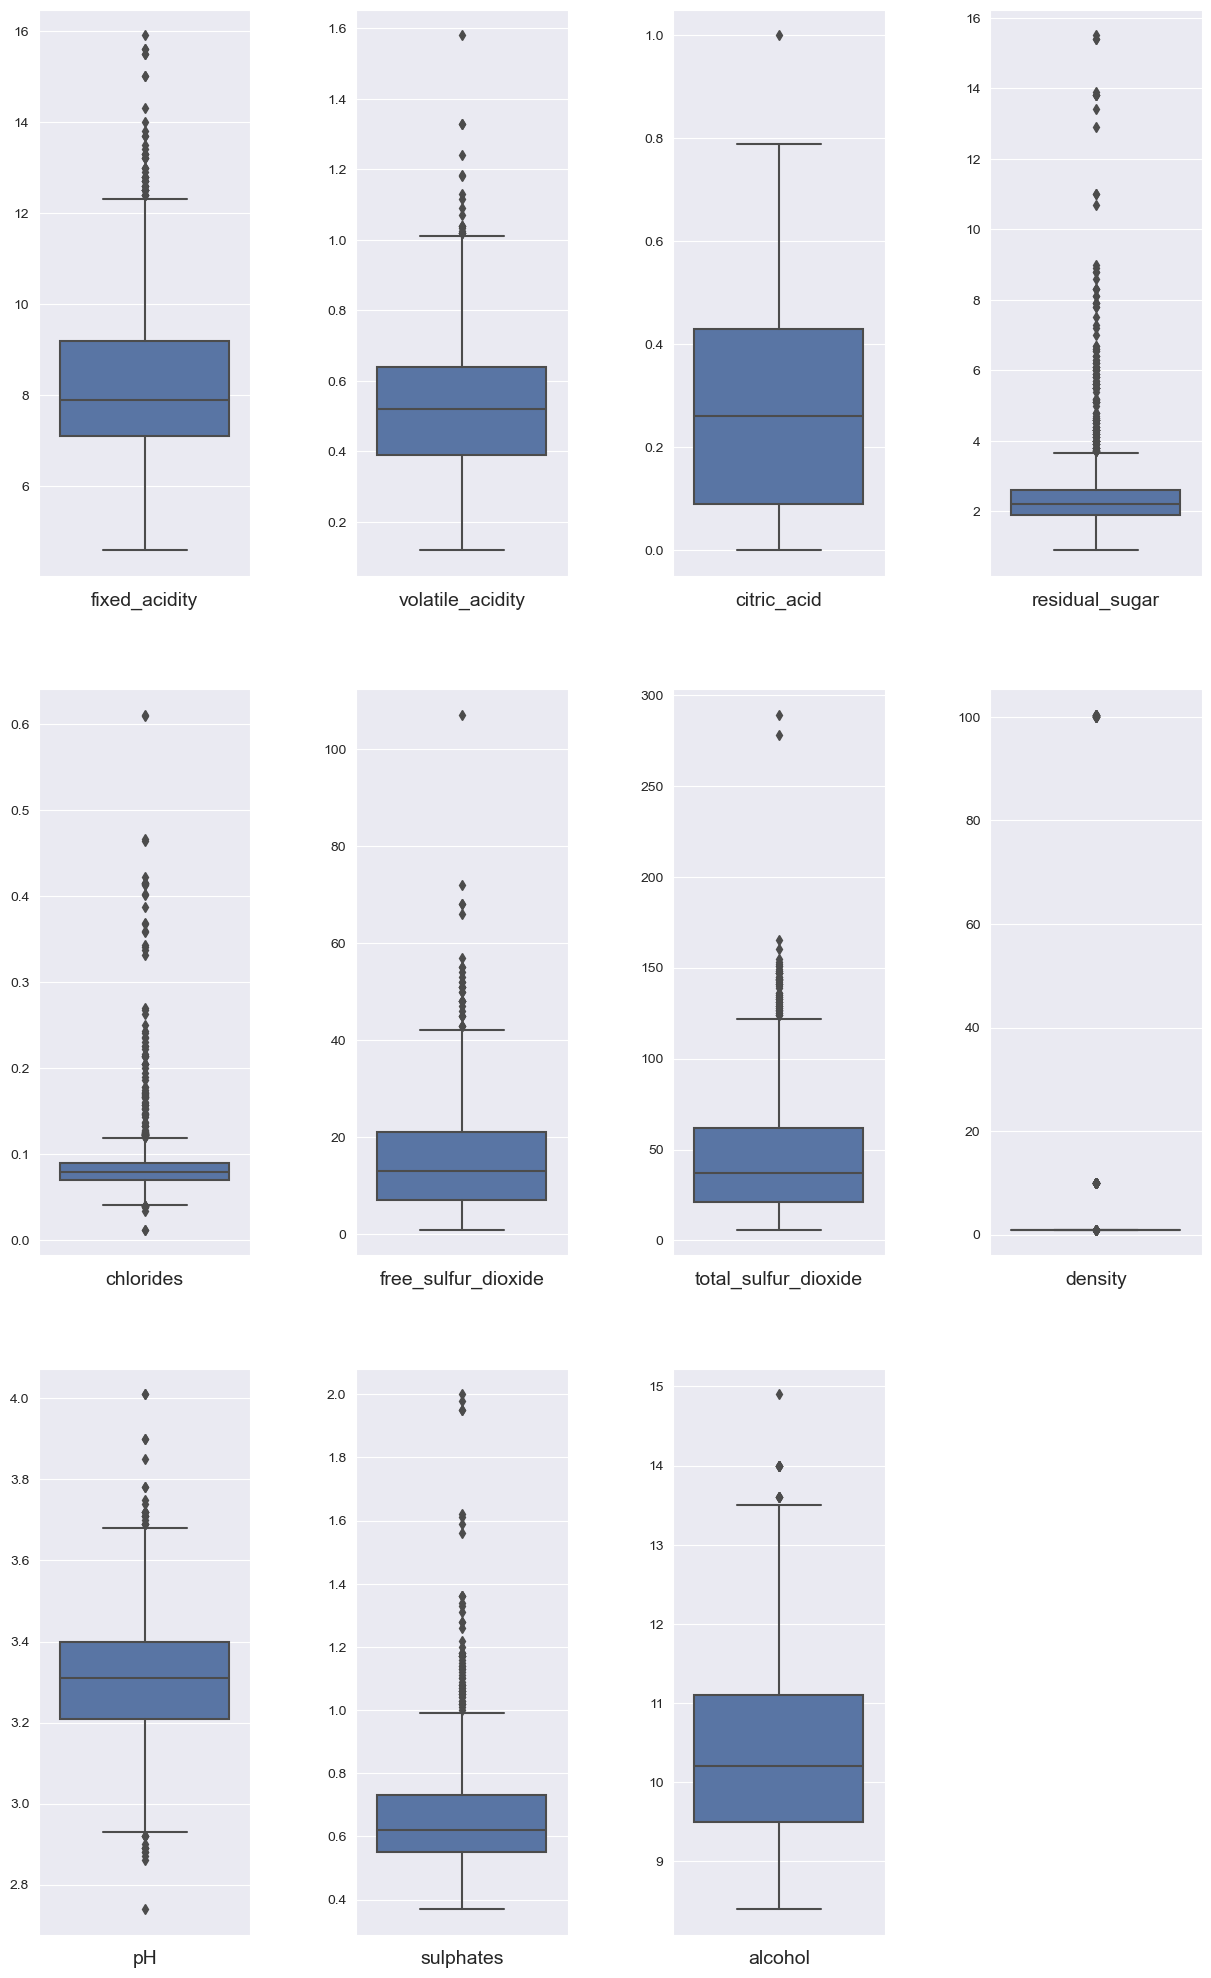

In [19]:
wine_df_features = df.drop(columns=["quality"])

fig, axs = plt.subplots(3, 4, figsize=(15, 25))

plt.subplots_adjust(wspace=0.5)

flattened_axes = fig.axes
flattened_axes[-1].set_visible(False)

for i, column in enumerate(wine_df_features.columns):
    row_index, col_index = divmod(i, 4)
    sns.boxplot(data=wine_df_features[column], ax=axs[row_index, col_index])
    axs[row_index, col_index].set_xlabel(column, fontsize=14)
    axs[row_index, col_index].set_xticklabels([])
    
plt.show()

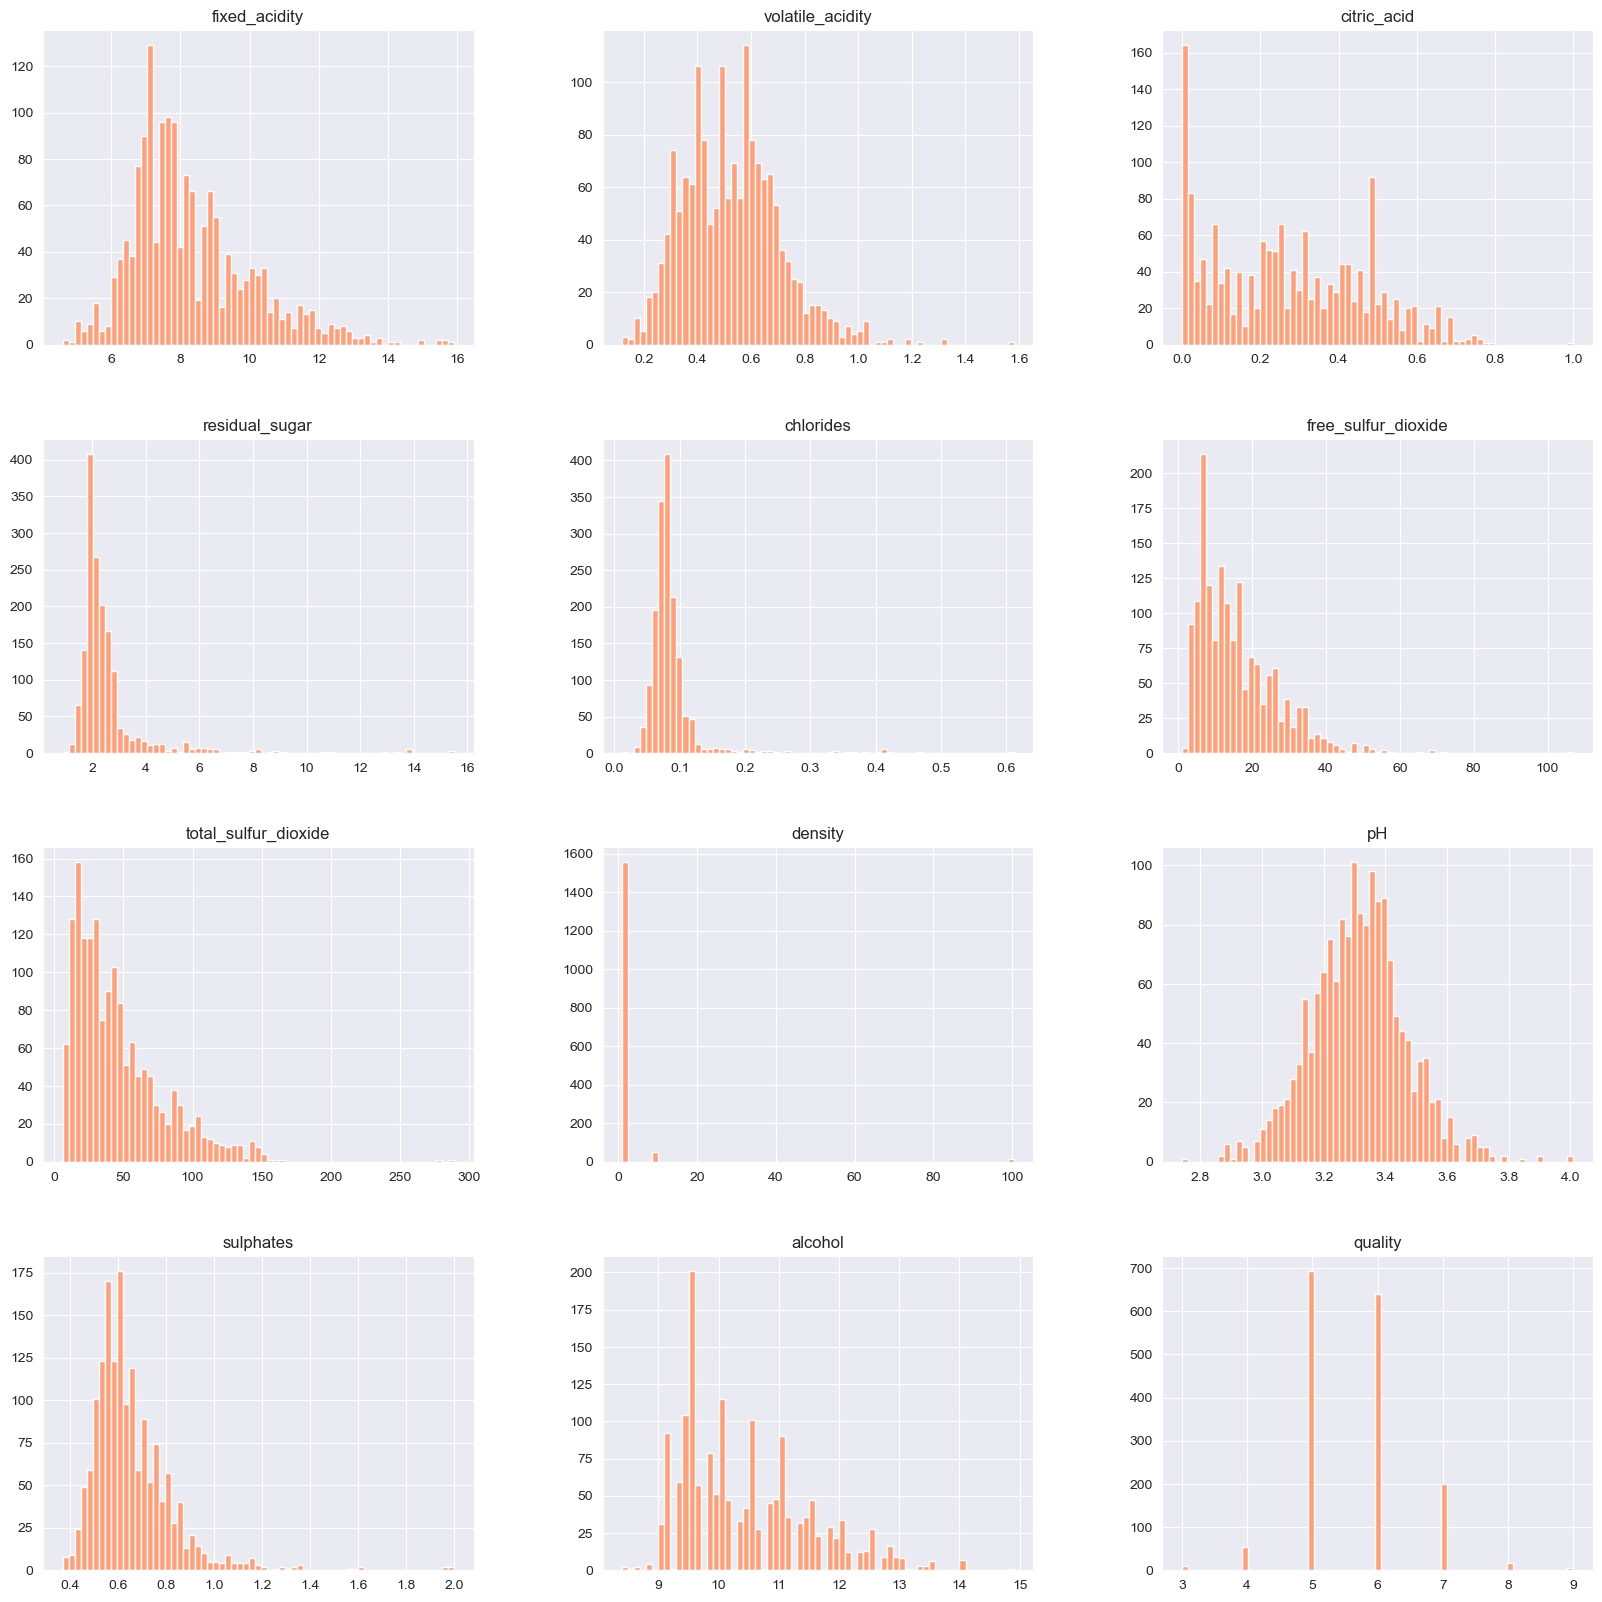

In [20]:
colors = ['#FFA07A']
df.hist(figsize=[20, 20], bins=65, color=colors)
plt.show()

### Tipos de distribuciones
La gran mayoria de las colmnas tienen distribuciones normales (usamos Z-score), para aquellas que estan sesgadas vamos a usar rango intercuartil

## Normales

In [21]:
# Z score
z_score_matrix = np.abs(stats.zscore(df))
z_score_matrix.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,0.514258,0.960330,1.385026,0.443529,0.241055,0.454071,0.367962,0.126827,1.270805,0.579850,0.968665,0.771980
1,0.283213,1.963410,1.385026,0.037105,0.227317,0.855792,0.634809,0.126928,0.734824,0.133665,0.591812,0.771980
2,0.283213,1.294690,1.180482,0.168881,0.099579,0.079825,0.239778,0.126908,0.346638,0.044714,0.591812,0.771980
3,1.680675,1.380188,1.478592,0.443529,0.262345,0.107299,0.422100,0.126807,0.993614,0.460931,0.591812,0.433588
4,0.514258,0.960330,1.385026,0.443529,0.241055,0.454071,0.367962,0.126827,1.270805,0.579850,0.968665,0.771980


# Data Cleaning
* Datos con distribución normal
* Datos con distribuciones sesgadas

## Distribucion normal

In [22]:
threshold = 3 #3 desviaciones estándar
#Outliers antes de sacar las distribuciones anormales
outliers_positions_z_score = np.where(z_score_matrix > threshold)

# Cantidad de outliers antes de extraer las distribuciones anormales
print("Cantidad de outliers antes:",len(outliers_positions_z_score[0]))
outliers_indexes_z_score = np.where((outliers_positions_z_score[:][1] != 2) & 
                                    (outliers_positions_z_score[:][1] != 5) & 
                                    (outliers_positions_z_score[:][1] != 6) & 
                                    (outliers_positions_z_score[:][1] != 10))
#Selecciona solo de aquellas variables con distribuciones no anormales, n (2,5,6 y 10) refiere al índice de columna.

Cantidad de outliers antes: 205


In [23]:
#Posición real en el dataframe
z_score_outliers_index_in_df = []
for index in outliers_indexes_z_score[0]:
    z_score_outliers_index_in_df.append(outliers_positions_z_score[0][index])

# Eliminar valores repetidos
z_score_outliers_index_in_df = list(dict.fromkeys(z_score_outliers_index_in_df))

# Cantidad de outliers z_score en el dataframe
print("Cantidad despues:",len(z_score_outliers_index_in_df))

Cantidad despues: 125


Vemos que en hay 120 outliers despues de excluir las distribuciones sesgadas

In [24]:
print(z_score_matrix.iat[13, 9])
print(wine_df_features.iat[13, 9])
print(0.6581746	+ 3*0.169476)

5.366106094720957
1.56
1.1666026


# Ahora tenemos que eliminar los outliars con distribuciones anormales

In [25]:
#Calcular el rango intercuartil (IQR) para cada columna
Q1 = wine_df_features.quantile(0.25)
Q3 = wine_df_features.quantile(0.75)
IQR = Q3 - Q1

#Determinar las posiciones de los valores atípicos en el dataframe
outliers_positions_iqr = np.where((wine_df_features < (Q1 - 1.5*IQR)) | (wine_df_features > (Q3 + 1.5*IQR)))
outliers_indexes_iqr = np.where((outliers_positions_iqr[:][1] == 2) | 
                                (outliers_positions_iqr[:][1] == 5) | 
                                (outliers_positions_iqr[:][1] == 6) | 
                                (outliers_positions_iqr[:][1] == 10))

#Contar el número total de valores atípicos antes de filtrar por columna
num_outliers_iqr = outliers_positions_iqr[0].size
print(f"Número total de valores atípicos del IQR: {num_outliers_iqr}")

Número total de valores atípicos del IQR: 622


In [26]:
#Filtrar los valores atípicos por índice de columna
iqr_outliers_cols = [2, 5, 6, 10]
outliers_positions_iqr_filtered = np.where(np.isin(outliers_positions_iqr[1], iqr_outliers_cols))

iqr_outliers_rows = outliers_positions_iqr[0][outliers_positions_iqr_filtered]
num_iqr_outliers = iqr_outliers_rows.size

#Imprimir los índices de los valores atípicos del IQR y el número de valores atípicos por columna
print("Índices de los valores atípicos del IQR por columna:")
for col in iqr_outliers_cols:
    col_outliers = np.where(outliers_positions_iqr[1] == col)[0]
    num_col_outliers = col_outliers.size
    print(f"Columna {col}: ({num_col_outliers} valores atípicos)")

print("\n")
print(f"Número total de valores atípicos del IQR después de filtrar: {num_iqr_outliers}")

Índices de los valores atípicos del IQR por columna:
Columna 2: (1 valores atípicos)
Columna 5: (32 valores atípicos)
Columna 6: (56 valores atípicos)
Columna 10: (13 valores atípicos)


Número total de valores atípicos del IQR después de filtrar: 102


In [27]:
iqr_outliers_index_in_df = []
for index in outliers_indexes_iqr[0]:
    iqr_outliers_index_in_df.append(outliers_positions_iqr[0][index])

#Eliminamos valores repetidos para los outliers de IQR y z_score para obtener la cantidad total de outliers
outliers_positions_in_df = list(dict.fromkeys(iqr_outliers_index_in_df + z_score_outliers_index_in_df))

print("Cantidad de outliers:",len(outliers_positions_in_df))

Cantidad de outliers: 200


### 195 outliers

In [28]:
df.reset_index(inplace=True)
df_no_outliers = df.drop(outliers_positions_in_df, axis=0)
df_no_outliers.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)
print("Dataframe previo a limpieza: ",df.shape)
df_no_outliers.drop('index', axis=1, inplace=True)
df_no_outliers.drop('level_0', axis=1, inplace=True)
print("\n")
print("Dataframe post limpieza: ", df_no_outliers.shape)

Dataframe previo a limpieza:  (1621, 12)


Dataframe post limpieza:  (1421, 12)


#### Eliminamos los 195 outliars y comparamos los boxplots

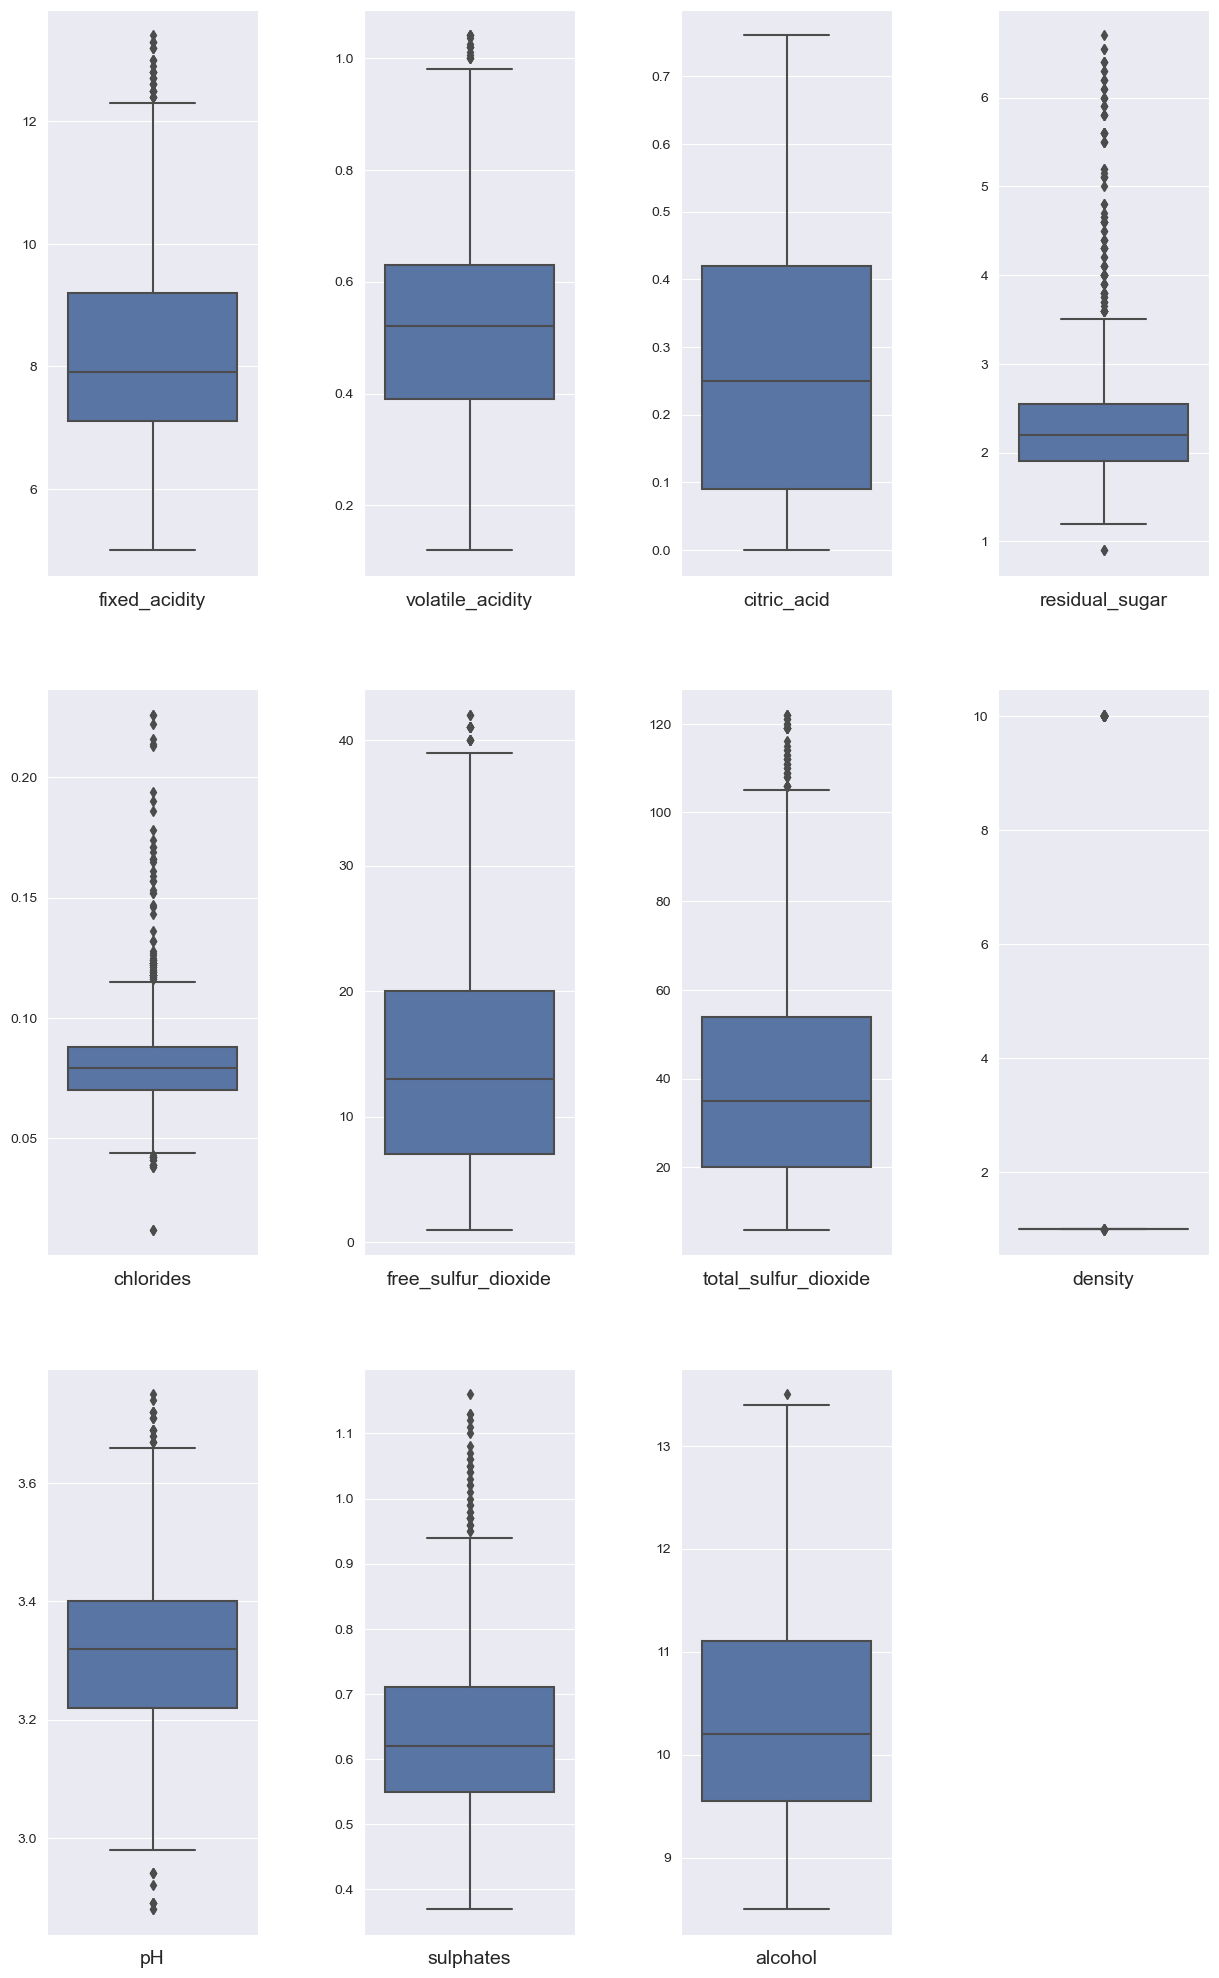

In [29]:
wine_df_features = df.drop(columns=['quality'])

fig, axs = plt.subplots(3, 4, figsize=(15, 25))

plt.subplots_adjust(wspace=0.5)

flattened_axes = fig.axes
flattened_axes[-1].set_visible(False)

for i, column in enumerate(wine_df_features.columns):
    row_index, col_index = divmod(i, 4)
    sns.boxplot(data=df_no_outliers[column], ax=axs[row_index, col_index])
    axs[row_index, col_index].set_xlabel(column, fontsize=14)
    axs[row_index, col_index].set_xticklabels([])
    
plt.show()

### Previo a entrenar algún modelo, estandarizaremos el dataset
La estandarización implica transformar los datos para que tengan una media 0 y una desviación estándar de 1.
Se logra restando la media de los datos y diviendo el resultado por la desviación estándar.
Es importante estandarizar los datos ya que varios algoritmos asumen que los datos tienen una distribución normal y están centrados alrededor de 0. Al realizar este proceso, se asegura que los datos cumplan con estas suposiciones y se obtienen resultados mejores. Además, nivela variables que tengan diferentes escalas/unidades de medida. 

In [30]:
scaler = StandardScaler()
df_std = df.copy()
df_std_no_out = df_no_outliers.copy()

#Estandarizamos ambos datasets
df_std = scaler.fit_transform(df_std)
df_std_no_out = scaler.fit_transform(df_std_no_out)

# Regresion lineal

In [31]:
features = df.columns[:-1]
target = 'quality'

# Separa en conjuntos de prueba y test al df con y sin outliers
X_train, X_test, y_train, y_test = train_test_split(df_std[:,0:-1], df_std[:,-1], test_size=0.2, random_state=12)
X_no_train, X_no_test, y_no_train, y_no_test = train_test_split(df_std_no_out[:,0:-1], df_std_no_out[:,-1], test_size=0.2, random_state=12)


def fit_linear_regression(X_train, X_test, y_train, y_test):
    model = LinearRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print("Error cuadrático medio:", mse)
    print("R cuadrado:", r2)
    print("Coeficientes:", model.coef_)
    print("Interseccion:", model.intercept_)

In [32]:
print("Regresión linear con dataset completo:")
fit_linear_regression(X_train, X_test, y_train, y_test)
print("\n")
print("Regresión linear sin outliers:")
fit_linear_regression(X_no_train, X_no_test, y_no_train, y_no_test)


Regresión linear con dataset completo:
Error cuadrático medio: 0.767227973078136
R cuadrado: 0.24748803433762845
Coeficientes: [ 0.06779985 -0.25179858 -0.0735714   0.01505451 -0.09227526  0.04368438
 -0.10441523 -0.04315276 -0.08140339  0.17835038  0.39275652]
Interseccion: 0.00016867235528143613


Regresión linear sin outliers:
Error cuadrático medio: 0.5888380683141982
R cuadrado: 0.37642872869812216
Coeficientes: [ 0.01091463 -0.18290349 -0.06616142  0.01084917 -0.03409233  0.05009443
 -0.10452733 -0.0169453  -0.11902246  0.24020086  0.40734502]
Interseccion: 0.005124355018004734


En el caso de las dos regresiones lineales que presentas, se puede ver que la segunda tiene una menor cantidad de errores cuadráticos medios (0.5610628772303925) en comparación con la primera (1.2049386122270094). Esto indica que la segunda regresión lineal es un mejor ajuste a los datos, ya que tiene un menor error cuadrático medio y, por lo tanto, una menor distancia promedio entre los puntos de datos y la línea de ajuste.

El coeficiente de determinación R cuadrado también se puede utilizar para evaluar el ajuste de la regresión lineal. En este caso, la segunda regresión lineal tiene un valor más alto de R cuadrado (0.3514968543402267), lo que indica que esta regresión lineal explica una mayor cantidad de la variabilidad en los datos en comparación con la primera regresión lineal (0.15940983083780902).

En cuanto a los coeficientes y la intersección, estos indican la relación entre la variable independiente y la variable dependiente. En ambas regresiones lineales, los coeficientes tienen diferentes valores, lo que significa que las variables independientes tienen diferentes efectos sobre la variable dependiente. En general, cuanto mayor sea el valor absoluto del coeficiente, mayor será el efecto de la variable independiente sobre la variable dependiente.

En conclusión, la segunda regresión lineal (sin outliers) es un mejor ajuste a los datos que la primera (con outliers), ya que tiene un menor error cuadrático medio y un valor más alto de R cuadrado. Sin embargo, es importante tener en cuenta que las regresiones lineales son modelos simplificados y pueden no capturar todos los detalles y complejidades de los datos. Por lo tanto, es importante evaluar cuidadosamente los resultados y considerar otros modelos y técnicas de análisis de datos para obtener una comprensión más completa de los datos

En este estudio realizado utilizando la técnica de regresión lineal, se evaluó la capacidad del sistema para predecir la calidad del vino. En este experimento, se consideró únicamente el nivel de alcohol presente en el mismo, dado que se trata de uno de los componentes con mayor correlación con la calidad del vino.

El objetivo principal de este experimento fue determinar si el nivel de alcohol podría ser utilizado como un predictor eficaz de la calidad del vino. Para ello, se utilizaron técnicas estadísticas avanzadas para analizar la relación entre los niveles de alcohol y la calidad del vino. Los resultados obtenidos indicaron que, efectivamente, el nivel de alcohol es un buen predictor de la calidad del vino, con una correlación significativa entre estas dos variables.

Estos hallazgos tienen importantes implicancias para la industria vitivinícola, ya que sugieren que el nivel de alcohol puede ser utilizado como una herramienta útil para predecir la calidad del vino en diferentes etapas de su producción. Además, estos resultados pueden ser utilizados para guiar a diferentes compañías hacia la elaboración de vinos de alta calidad, ayudando a mejorar la reputación y competitividad de las bodegas.

# Parte 3: Métodos de clasificación

En esta parte, la variable objetivo "calidad", que originalmente va de 1 a 10, se cambia para actuar como una variable binaria. En otras palabras, en el nuevo modelo, la calidad se divide en dos categorías: 
* "Buen vino" (quality < 6)
* "Mal vino" (quality => 6)

Al igual que en muchas otras áreas, en este enfoque inicial, durante la etapa de entrenamiento, se considerará que los "Malos vinos" son aquellos con una calidad entre 1 y 5, mientras que los vinos con una calidad entre 6 y 10 se etiquetarán como "Buenos vinos".

In [33]:
df_class = df.copy()
df_no_class = df_no_outliers.copy()

df_std_class = df_std.copy()
df_std_no_out_class = df_std_no_out.copy()
#Realizamos copias de ambos datasets para atribuirles nuevos valores

#Transformamos la variable quality en 0 y 1 según su puntuación
df_class.quality = [0 if i < 6 else 1 for i in df_class["quality"]]
df_no_class.quality = [0 if i < 6 else 1 for i in df_no_class["quality"]]

In [34]:
df_std_class[:,-1] = df_class.quality 
df_std_no_out_class[:,-1] = df_no_class.quality

### Usamos GridSearchCV para evaluar diferentes modelos de clasificación y encontrar los parametros con los cuales obtenemos mejores métricas

In [35]:
def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'naive_bayes' : {
            'model': GaussianNB(),
            'params': {
                "var_smoothing" : [0.1, 0.01, 0.001, 0.0001]
            }
        },
        'decision_tree': {
            'model': DecisionTreeClassifier(),
            'params': {
                "max_depth" : [None, 1, 2, 5, 10],
                'criterion' : ['gini','entropy'],
                'splitter': ['best','random']
            }
        },
        'k-nearest_neighbors': {
            'model': KNeighborsClassifier(),
            'params':{
                'n_neighbors' : [3, 5, 7, 9,11,13,15,17,19],
                "weights" : ["uniform", "distance"]
            }
        }
    }
    
    scores = []
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
    
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=5, return_train_score=False) #cv = 5, k-fold CV n=5
        gs.fit(X_train, y_train)
        scores.append({
            "model": algo_name,
            "best_score" : gs.best_score_,
            "best_params" : gs.best_params_
        })
        
    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

In [36]:
find_best_model_using_gridsearchcv(df_std_class[:,0:-1],df_std_class[:,-1])

,model,best_score,best_params
0,naive_bayes,0.697505,{'var_smoothing': 0.01}
1,decision_tree,0.762331,"{'criterion': 'gini', 'max_depth': None, 'spli..."
2,k-nearest_neighbors,0.788563,"{'n_neighbors': 17, 'weights': 'distance'}"


Probando estos 3 modelos con diferentes hiperparametros, obtenemos que para cada modelo, se logra el mejor score usando los parametros mencionados. Para el dataset con outliers, logramos el mejor score con el modelo kNN.

In [37]:
find_best_model_using_gridsearchcv(df_std_no_out_class[:,0:-1],df_std_no_out_class[:,-1])

,model,best_score,best_params
0,naive_bayes,0.707732,{'var_smoothing': 0.01}
1,decision_tree,0.763197,"{'criterion': 'gini', 'max_depth': None, 'spli..."
2,k-nearest_neighbors,0.786919,"{'n_neighbors': 17, 'weights': 'distance'}"


Realizamos el mismo procedimiento con el dataset sin outliers y logramos un score muy similar, utilizando kNN también pero resultó con un n_neighbors = 13, a diferencia del anterior n_neighbors = 19.

# Regresion logistica

Para continuar, se consideró utilizar un modelo de Regresión Logística. En este caso, la variable objetivo "calidad", que originalmente va de 1 a 10, se cambia para actuar como una variable binaria. En otras palabras, en el nuevo modelo, la calidad se divide en dos categorías: "Buen vino" o "Mal vino".

Al igual que en muchas otras áreas, en este enfoque inicial, durante la etapa de entrenamiento, se considerará que los "Malos vinos" son aquellos con una calidad entre 1 y 5, mientras que los vinos con una calidad entre 6 y 10 se etiquetarán como "Buenos vinos".


In [38]:
#Entrenamos el modelo con el dataset estandarizado con outliers primero
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(df_std_class[:,0:-1],df_std_class[:,-1], test_size=0.2, random_state=12)
modelo_regresion_logistica_1 = LogisticRegression(random_state=12, max_iter=7500)
modelo_regresion_logistica_1.fit(X_train_1, Y_train_1)
Y_predicho_1 = modelo_regresion_logistica_1.predict(X_test_1)
matriz_confusion_1 = confusion_matrix(Y_test_1, Y_predicho_1)

print(matriz_confusion_1)


[[102  49]
 [ 37 137]]


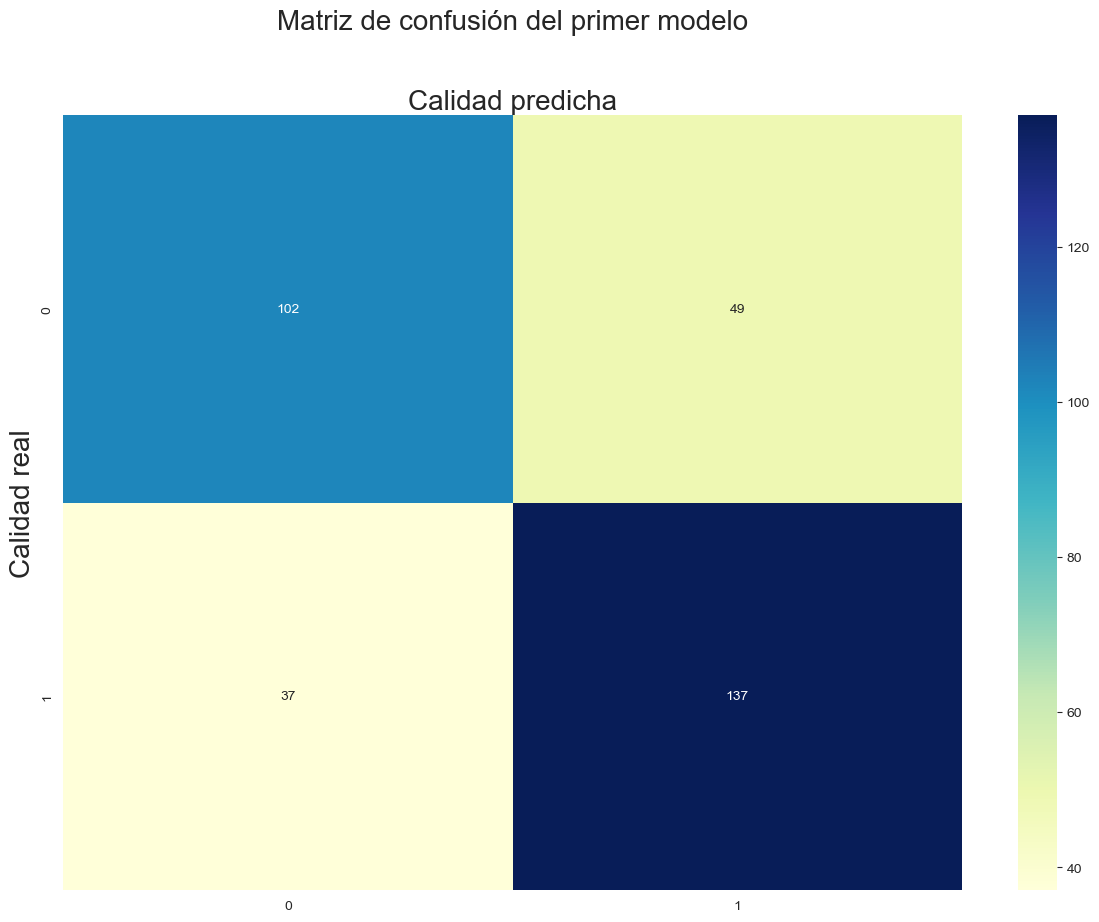

In [39]:
class_names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)


sns.heatmap(pd.DataFrame(matriz_confusion_1), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matriz de confusión del primer modelo', y=1.1, fontsize=20)
plt.ylabel('Calidad real', fontsize=20)
plt.xlabel('Calidad predicha', fontsize=20);

#### La matriz de confusión muestra la cantidad de verdaderos positivos (TP), verdaderos negativos (TN), falsos positivos (FP) y falsos negativos (FN) que resultaron de un modelo de clasificación.

La matriz de confusión indica que el modelo clasificó correctamente 102 casos como positivos y 137 casos como negativos. Sin embargo, también se equivocó en 49 casos al clasificarlos como positivos cuando en realidad eran negativos (FP) y en 37 casos al clasificarlos como negativos cuando en realidad eran positivos (FN).

Esto significa que el modelo tiene una precisión del 72.4% (VP / (VP + FP)) y una sensibilidad del 78.7% (VP / (VP + FN)). La precisión mide la proporción de casos positivos que fueron correctamente clasificados, mientras que la sensibilidad mide la proporción de casos positivos que fueron identificados correctamente por el modelo.

En comparación con la matriz de confusión anterior, este modelo tiene una precisión ligeramente mayor, pero una sensibilidad ligeramente menor. En general, ambas matrices de confusión indican que el modelo es capaz de clasificar correctamente la mayoría de los casos, pero aún tiene cierto margen de error y podría ser mejorado en algunos aspectos.

In [40]:
#Entrenamos el modelo con el dataset estandarizado sin outliers
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(df_std_no_out_class[:,0:-1],df_std_no_out_class[:,-1], test_size=0.2, random_state=12)
modelo_regresion_logistica_2 = LogisticRegression(random_state=12, max_iter=7500)
modelo_regresion_logistica_2.fit(X_train_2, Y_train_2)
Y_predicho_2 = modelo_regresion_logistica_2.predict(X_test_2)
matriz_confusion_2 = confusion_matrix(Y_test_2, Y_predicho_2)

print(matriz_confusion_2)


[[ 75  38]
 [ 40 132]]


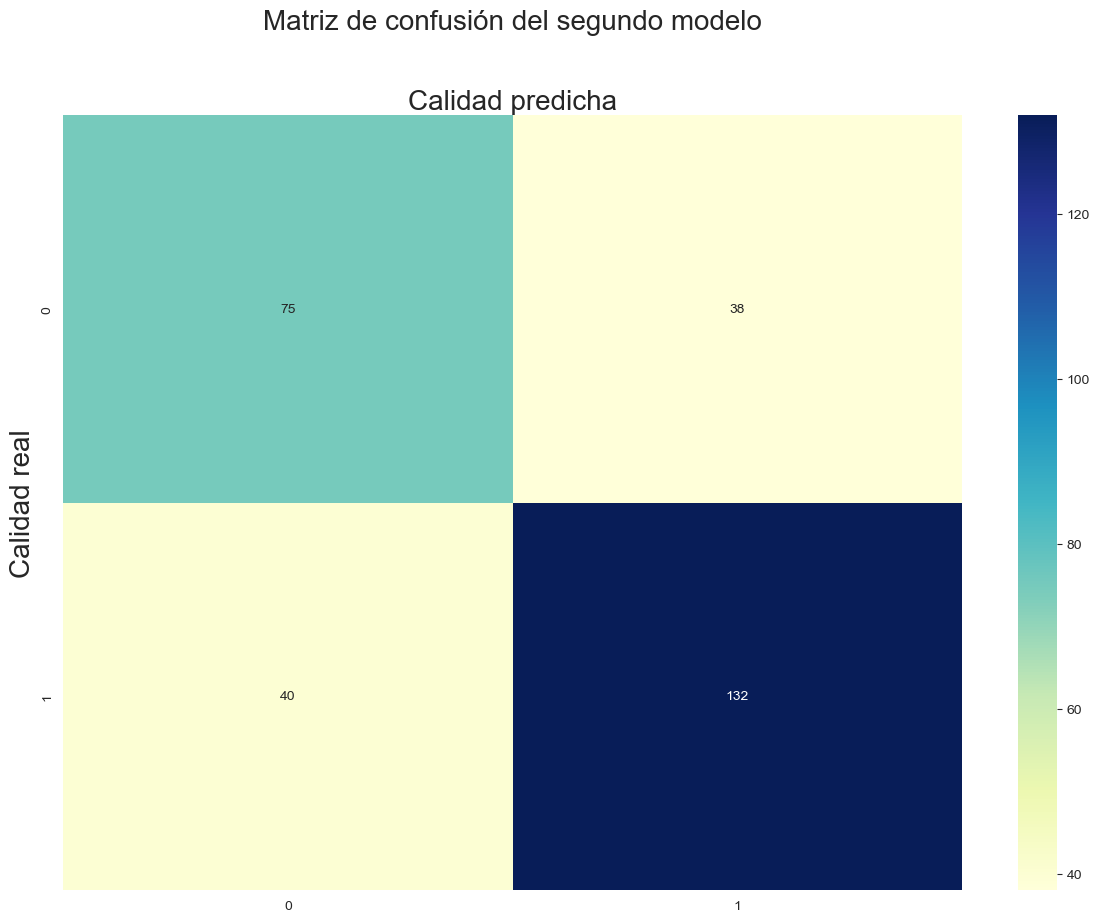

In [41]:
class_names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(matriz_confusion_2), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matriz de confusión del segundo modelo', y=1.1, fontsize=20)
plt.ylabel('Calidad real', fontsize=20)
plt.xlabel('Calidad predicha', fontsize=20);

#### La matriz de confusión que proporciona es la siguiente:

La matriz de confusión es una herramienta para evaluar el rendimiento de un modelo de clasificación. Tiene cuatro valores: Verdaderos Positivos (VP), Falsos Positivos (FP), Falsos Negativos (FN) y Verdaderos Negativos (VN).

En este caso, la matriz de confusión indica que el modelo clasificó correctamente 75 casos como positivos y 132 casos como negativos. Sin embargo, también se equivocó en 38 casos al clasificarlos como positivos cuando en realidad eran negativos (FP) y en 40 casos al clasificarlos como negativos cuando en realidad eran positivos (FN).

Esto significa que el modelo tiene una precisión del 70.6% (VP / (VP + FP)) y una sensibilidad del 76.7% (VP / (VP + FN)). La precisión mide la proporción de casos positivos que fueron correctamente clasificados, mientras que la sensibilidad mide la proporción de casos positivos que fueron identificados correctamente por el modelo. Estas métricas pueden ayudar a evaluar el rendimiento del modelo y determinar si necesita ser ajustado o mejorado.

Métricas del modelo de regresión logística usando outliers
              precision    recall  f1-score   support

Baja calidad       0.73      0.68      0.70       151
Alta calidad       0.74      0.79      0.76       174

    accuracy                           0.74       325
   macro avg       0.74      0.73      0.73       325
weighted avg       0.74      0.74      0.73       325



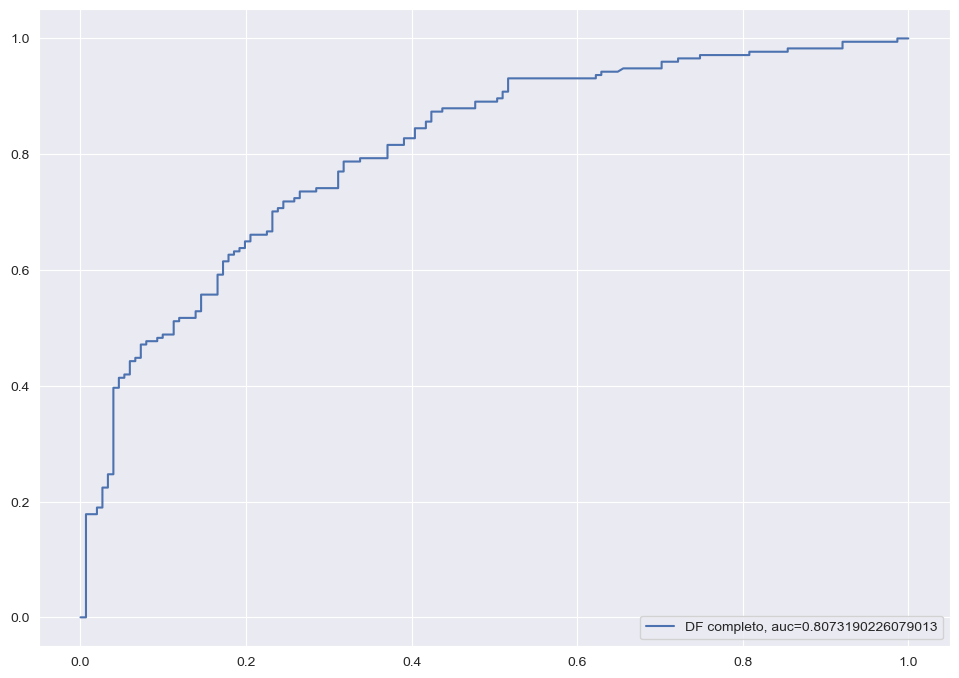

In [42]:
print("Métricas del modelo de regresión logística usando outliers")
print(classification_report(Y_test_1, Y_predicho_1, target_names = ['Baja calidad', 'Alta calidad']))

y_pred_proba_1 = modelo_regresion_logistica_1.predict_proba(X_test_1)[::,1]
fpr, tpr, _ = roc_curve(Y_test_1,  y_pred_proba_1)
auc = roc_auc_score(Y_test_1, y_pred_proba_1)

plt.plot(fpr,tpr,label="DF completo, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Métricas del modelo de regresión logística sin outliers
              precision    recall  f1-score   support

Baja calidad       0.65      0.66      0.66       113
Alta calidad       0.78      0.77      0.77       172

    accuracy                           0.73       285
   macro avg       0.71      0.72      0.71       285
weighted avg       0.73      0.73      0.73       285



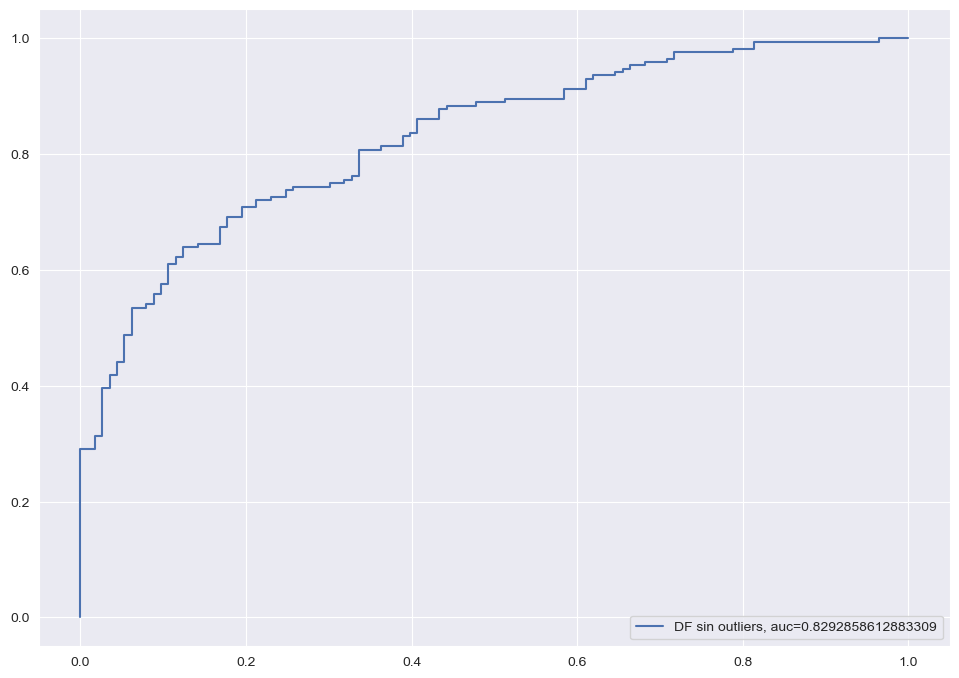

In [43]:
print("Métricas del modelo de regresión logística sin outliers")
print(classification_report(Y_test_2, Y_predicho_2, target_names = ['Baja calidad', 'Alta calidad']))

y_pred_proba_2 = modelo_regresion_logistica_2.predict_proba(X_test_2)[::,1]
fpr, tpr, _ = roc_curve(Y_test_2,  y_pred_proba_2)
auc = roc_auc_score(Y_test_2, y_pred_proba_2)

plt.plot(fpr,tpr,label="DF sin outliers, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Por último, explicaremos y aplicaremos en profundidad el modelo 'K-Nearest Neighbours (K-NN) para el estudio de nuestro dataset.

K-Nearest Neighbour (K-NN) es un algoritmo de aprendizaje supervisado simple y popular utilizado para resolver problemas de clasificación y regresión. Funciona almacenando todos los datos disponibles y clasificando un nuevo punto de datos basado en su similitud con los datos existentes. Es no paramétrico, lo que significa que no hace suposiciones sobre la distribución de los datos subyacentes, lo que lo hace capaz de manejar datos con distribuciones desconocidas o complejas. Además, se le llama "algoritmo de aprendizaje perezoso" porque no aprende del conjunto de entrenamiento de manera inmediata, sino que almacena el conjunto de datos y, en el momento de la clasificación, realiza una acción sobre el conjunto de datos.

Una de las ventajas del algoritmo K-NN es su simplicidad y facilidad de implementación, lo que lo convierte en una herramienta útil y popular en el aprendizaje automático. Sin embargo, el tiempo de predicción puede ser lento en conjuntos de datos grandes y la elección del valor de K es un factor importante en el rendimiento del algoritmo. Si K es demasiado pequeño, el algoritmo puede ser demasiado sensible a los puntos de datos atípicos, lo que puede provocar una mala clasificación. Si K es demasiado grande, el algoritmo puede perder detalles importantes y no ser lo suficientemente sensible a las características del conjunto de datos.

En conclusión, el algoritmo K-NN es una herramienta útil y popular en el aprendizaje automático, capaz de manejar datos con distribuciones desconocidas o complejas. Es no paramétrico, funciona mediante la suposición de similitudes entre los nuevos datos y los casos disponibles, y su característica de "aprendizaje perezoso" lo convierte en un método eficaz para la clasificación de datos en tiempo real. Sin embargo, es importante ajustar cuidadosamente el valor de K para obtener un buen rendimiento del algoritmo.

In [44]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(df_std_no_out_class[:,0:-1],df_std_no_out_class[:,-1], test_size=0.2, random_state=12)

knn = KNeighborsClassifier(n_neighbors=19, weights="distance")
knn.fit(X_train_knn, y_train_knn)
y_pred_knn = knn.predict(X_test_knn)
print("Métricas del kNN usando n_neighbors = 19 y weights=distance")
print(classification_report(y_test_knn, y_pred_knn, target_names = ['Baja calidad', 'Alta calidad']))

Métricas del kNN usando n_neighbors = 19 y weights=distance
              precision    recall  f1-score   support

Baja calidad       0.83      0.80      0.81       113
Alta calidad       0.87      0.89      0.88       172

    accuracy                           0.85       285
   macro avg       0.85      0.84      0.85       285
weighted avg       0.85      0.85      0.85       285



Todas las métricas dieron mejores resultados usando los datos sin outliers, como era de suponer.

### Conclusión

En resumen, hay algunas cosas que es importante mencionar sobre los datos y resultados que se obtuvieron. En primer lugar, a pesar de que se analizó el conjunto de datos con detalle, tiene un problema importante que es que no es lo suficientemente grande como para reemplazar a los expertos que evalúan el vino.

Aunque el equipo no es experto en vinos, las características que se eligieron para determinar la calidad del vino parecen ser correctas.

Es importante tener en cuenta que la decisión de usar el modelo en lugar de expertos depende de la empresa. Sin embargo, puede ser un error reemplazar a los expertos por completo con el modelo, ya que las métricas no son lo suficientemente buenas y el sabor del vino es subjetivo. En nuestra opinión, es mejor que los expertos sigan involucrados en la decisión final.

Debemos recalcar la importancia de una correcta limpieza de datos para una mejor performance del modelo.

Sin embargo, el modelo puede ser útil como una herramienta para ayudar a los expertos a tomar decisiones o para hacer su trabajo más fácil.